In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import os

### VDSR (Very Deep Super Resolution)

In [15]:

class VDSR(nn.Module):
    def __init__(self):
        super(VDSR, self).__init__()
        self.residual_layer = self._make_layer(64, 20)
        self.input_layer = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.output_layer = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def _make_layer(self, channels, num_layers):
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.input_layer(x)
        out = self.residual_layer(out)
        out = self.output_layer(out)
        return out + residual

def enhance_image(image_path, model_path=None, scale_factor=2, show_result=True, save_path=None):
    """
    Enhance an image using VDSR super-resolution model.
    
    Args:
        image_path (str): Path to the input image
        model_path (str, optional): Path to pretrained model weights
        scale_factor (int, optional): Factor by which to upscale the image (default: 2)
        show_result (bool, optional): Whether to display the results (default: True)
        save_path (str, optional): Path to save the enhanced image (default: None)
    
    Returns:
        tuple: (original_image, enhanced_image) as PIL Images
    """
    try:
        # Check if image exists
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at {image_path}")

        # Device configuration
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize model
        model = VDSR().to(device)
        
        # Load model weights if provided
        if model_path:
            if os.path.exists(model_path):
                model.load_state_dict(torch.load(model_path, map_location=device))
            else:
                print(f"Warning: Model weights not found at {model_path}")
        
        # Load and prepare image
        image = Image.open(image_path).convert('RGB')
        
        # Define image transformation
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image.height * scale_factor, image.width * scale_factor)),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        # Prepare input
        input_image = transform(image).unsqueeze(0).to(device)
        
        # Model inference
        model.eval()
        with torch.no_grad():
            output_image_tensor = model(input_image)
        
        # Post-process output
        output_image_tensor = output_image_tensor.squeeze(0).clamp(0, 1).cpu()
        output_image = transforms.ToPILImage()(output_image_tensor)
        
        # Save enhanced image if path provided
        if save_path:
            output_image.save(save_path)
            print(f"Enhanced image saved to {save_path}")
        
        # Display results if requested
        if show_result:
            plt.figure(figsize=(12, 6))
            
            # Original image
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')
            
            # Enhanced image
            plt.subplot(1, 2, 2)
            plt.imshow(output_image)
            plt.title("Enhanced Image (VDSR)")
            plt.axis('off')
            
            plt.show()
        
        return image, output_image
        
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, None
"""
# With all options
original, enhanced = enhance_image(
    image_path='path/to/image.jpg',
    model_path='path/to/model_weights.pth',
    scale_factor=3,
    show_result=True,
    save_path='path/to/save/enhanced.jpg'
)
"""


"\n# With all options\noriginal, enhanced = enhance_image(\n    image_path='path/to/image.jpg',\n    model_path='path/to/model_weights.pth',\n    scale_factor=3,\n    show_result=True,\n    save_path='path/to/save/enhanced.jpg'\n)\n"

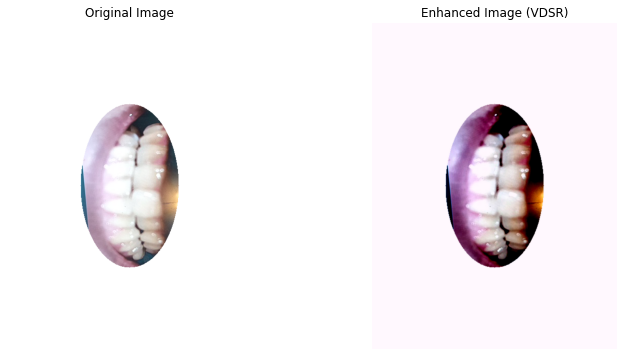

"\n# With all options\noriginal, enhanced = enhance_image(\n    image_path='path/to/image.jpg',\n    model_path='path/to/model_weights.pth',\n    scale_factor=3,\n    show_result=True,\n    save_path='path/to/save/enhanced.jpg'\n)\n"

In [14]:
# Example usage:

# Basic usage
original, enhanced = enhance_image('img.png')


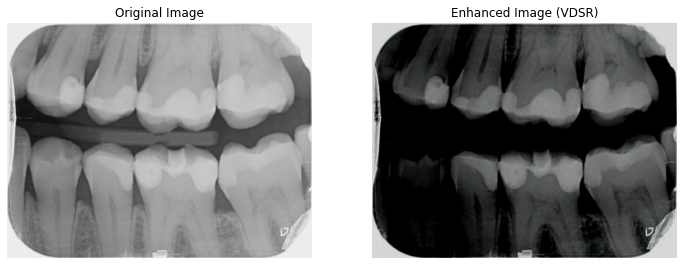

In [16]:
original, enhanced = enhance_image('img3.png')

### Super-Resolution and Image Enhancement using Bicubic U

In [18]:
def enhance_image_opencv(
    image_path,
    scale_factor=2,
    sharpness=1.0,
    clahe_clip=3.0,
    show_result=True,
    save_path=None
):
    """
    Enhance an image using OpenCV super-resolution and post-processing.
    
    Args:
        image_path (str): Path to the input image
        scale_factor (int, optional): Factor to upscale the image (default: 2)
        sharpness (float, optional): Sharpening intensity (default: 1.0)
        clahe_clip (float, optional): CLAHE clip limit (default: 3.0)
        show_result (bool, optional): Whether to display the results (default: True)
        save_path (str, optional): Path to save the enhanced image (default: None)
    
    Returns:
        tuple: (original_image, enhanced_image) as numpy arrays in RGB format
    """
    try:
        # Check if image exists
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at {image_path}")

        # Load the image
        input_img = cv2.imread(image_path)
        if input_img is None:
            raise ValueError("Failed to load the image. Check if the file is corrupted.")

        # Convert image from BGR to RGB
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

        # Apply super-resolution using bicubic interpolation
        h, w = input_img.shape[:2]
        new_h, new_w = h * scale_factor, w * scale_factor
        sr_img = cv2.resize(input_img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

        # Create sharpening kernel with adjustable intensity
        kernel_sharp = np.array([
            [0, -1 * sharpness, 0],
            [-1 * sharpness, 1 + 4 * sharpness, -1 * sharpness],
            [0, -1 * sharpness, 0]
        ])
        
        # Apply sharpening
        sharpened_img = cv2.filter2D(sr_img, -1, kernel_sharp)

        # Apply CLAHE in LAB color space
        lab = cv2.cvtColor(sharpened_img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        enhanced_final = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        # Save enhanced image if path provided
        if save_path:
            # Convert back to BGR for saving
            save_img = cv2.cvtColor(enhanced_final, cv2.COLOR_RGB2BGR)
            cv2.imwrite(save_path, save_img)
            print(f"Enhanced image saved to {save_path}")

        # Display results if requested
        if show_result:
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(input_img)
            ax[0].set_title("Original Image")
            ax[0].axis("off")
            
            ax[1].imshow(enhanced_final)
            ax[1].set_title("Enhanced Image (Super-Resolution + Sharpening)")
            ax[1].axis("off")
            
            plt.tight_layout()
            plt.show()

        return input_img, enhanced_final

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, None

# Example usage:
"""
# Basic usage
original, enhanced = enhance_image_opencv('path/to/image.png')

# Advanced usage with all options
original, enhanced = enhance_image_opencv(
    image_path='path/to/image.png',
    scale_factor=3,
    sharpness=1.5,
    clahe_clip=2.0,
    show_result=True,
    save_path='path/to/save/enhanced.png'
)

# Use without displaying
original, enhanced = enhance_image_opencv('path/to/image.png', show_result=False)
"""

"\n# Basic usage\noriginal, enhanced = enhance_image_opencv('path/to/image.png')\n\n# Advanced usage with all options\noriginal, enhanced = enhance_image_opencv(\n    image_path='path/to/image.png',\n    scale_factor=3,\n    sharpness=1.5,\n    clahe_clip=2.0,\n    show_result=True,\n    save_path='path/to/save/enhanced.png'\n)\n\n# Use without displaying\noriginal, enhanced = enhance_image_opencv('path/to/image.png', show_result=False)\n"

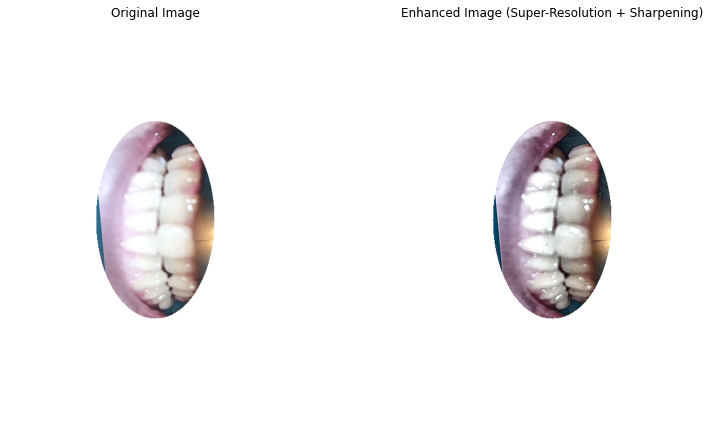

In [20]:
original, enhanced = enhance_image_opencv('img.png')


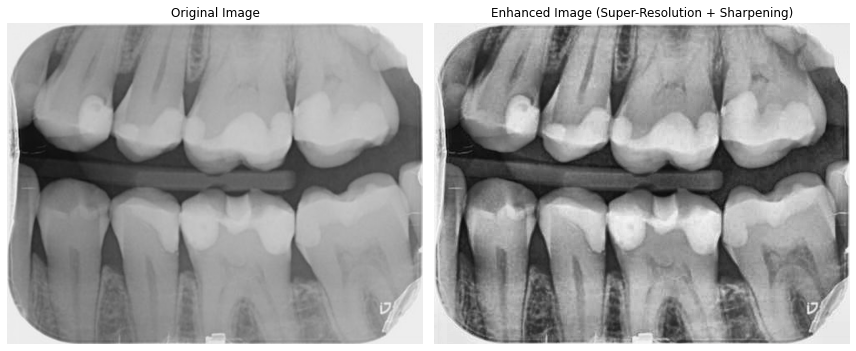

In [22]:
original, enhanced = enhance_image_opencv('img3.png')

### Advanced Dental Image Enhancement